In [ ]:
! pip list

In [2]:
%%capture
import sys

!"{sys.executable}" -m pip install phik
# !"{sys.executable}" -m pip install optuna
!"{sys.executable}" -m pip install shap

In [3]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 115.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [8]:
# Import libraries
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   MinMaxScaler,
                                   LabelEncoder,
                                   OrdinalEncoder)
from sklearn.metrics import (roc_auc_score,
                             f1_score,
                             confusion_matrix,
                             precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import shap

## Вводные данные <a class='anchor' id='1_1-bullet'></a>

In [10]:
# Create input parameters
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных <a class='anchor' id='2_1-bullet'></a>

In [11]:
def load_check_csv(source, sep=',', index_col=None, del_duplicates=False, decimal='.'):
    
    # Read csv
    if os.path.exists(source):
        df = pd.read_csv(source, sep=sep, index_col=index_col, decimal=decimal)
    elif os.path.exists(source[1:]):
        df = pd.read_csv(source, sep=sep, index_col=index_col, decimal=decimal)
    else:
        print('Check the source path or name!')
        
    
    # Display first rows
    print('Пример таблицы:')
    display(df.head())
    
    # Check info
    print('Основная информация по данным:')
    display(df.info())
    
    # Check for duplicates
    print('Колличество явных дупликатов:', df.duplicated().sum())
    print()
    
    if del_duplicates == True:
    
        if df.duplicated().sum() > 0:
            print('Удаление дупликатов и ресет индексов...')
            df = df.drop_duplicates().reset_index(drop=True)
        else:
            pass
        
    else:
        print('Дубликаты не удаляются.')
        pass
    
    # Missing values
    print('Колличество пропущенных значениях в столбцах:')
    missing_df = df.isna().sum()
    missing_df = pd.DataFrame(missing_df, columns = ['missing_count'])
    missing_df['missing_share'] = round((df.isna().sum() / len(df))* 100, 2)
    display(missing_df)
    
    return df

In [12]:
# Open and read csv
market_file = load_check_csv('/datasets/market_file.csv', index_col='id', del_duplicates=False)

Пример таблицы:


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Основная информация по данным:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64

None

Колличество явных дупликатов: 11

Дубликаты не удаляются.
Колличество пропущенных значениях в столбцах:


,missing_count,missing_share
Покупательская активность,0,0.0
Тип сервиса,0,0.0
Разрешить сообщать,0,0.0
Маркет_актив_6_мес,0,0.0
Маркет_актив_тек_мес,0,0.0
Длительность,0,0.0
Акционные_покупки,0,0.0
Популярная_категория,0,0.0
Средний_просмотр_категорий_за_визит,0,0.0
Неоплаченные_продукты_штук_квартал,0,0.0


In [13]:
# Open and read csv
market_money = load_check_csv('/datasets/market_money.csv', del_duplicates=False)

Пример таблицы:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Основная информация по данным:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Колличество явных дупликатов: 0

Дубликаты не удаляются.
Колличество пропущенных значениях в столбцах:


,missing_count,missing_share
id,0,0.0
Период,0,0.0
Выручка,0,0.0


In [14]:
# Open and read csv
market_time = load_check_csv('/datasets/market_time.csv', del_duplicates=False)

Пример таблицы:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Основная информация по данным:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Колличество явных дупликатов: 0

Дубликаты не удаляются.
Колличество пропущенных значениях в столбцах:


,missing_count,missing_share
id,0,0.0
Период,0,0.0
минут,0,0.0


In [15]:
# Open and read csv
money = load_check_csv('/datasets/money.csv', sep=';', index_col='id', del_duplicates=False, decimal=',')

Пример таблицы:


,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


Основная информация по данным:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


None

Колличество явных дупликатов: 900

Дубликаты не удаляются.
Колличество пропущенных значениях в столбцах:


,missing_count,missing_share
Прибыль,0,0.0


##  Предобработка данных  <a class='anchor' id='1_3-bullet'></a>

###  Названия столбцов  <a class='anchor' id='3_1-bullet'></a>

In [16]:
# Change the column names
def stand_columns_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(', ', ',', regex=True)
    df.columns = df.columns.str.replace('[ ,]', '_', regex=True)

In [17]:
# Apply the function
stand_columns_names(market_file)
stand_columns_names(market_money)
stand_columns_names(market_time)
stand_columns_names(money)
display(market_file.columns)

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

### Неявные дупликаты <a class='anchor' id='3_2-bullet'></a>

In [18]:
# Values mapping
market_time['период'] = market_time['период'].replace(['предыдцщий_месяц'], 'предыдущий_месяц', regex=True)
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace(['стандартт'], 'стандарт', regex=True)

### Пивот данных <a class='anchor' id='3_4-bullet'></a>

In [19]:
# Pivoting the table
market_money = market_money.pivot(index='id', columns='период', values='выручка')

# Renaming columns
market_money.columns = [f"{col}_выручка" for col in market_money.columns]

display(market_money.head())

,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [20]:
# Pivoting the table
market_time = market_time.pivot(index='id', columns='период', values='минут')

# Renaming columns
market_time.columns = [f"{col}_минут" for col in market_time.columns]

display(market_time.head())

,предыдущий_месяц_минут,текущий_месяц_минут
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


**Вывод:**
Мы стадиртизовали имена колонок, изменили тип данных некоторых колонок для удобства, проверили данные на неявные дупликаты, сделали пивот для некоторых таблиц, чтобы у нас на каждого покупателя была одна строчка.

## Исследовательский анализ данных <a class='anchor' id='1_3-bullet'></a>

### Количественные признаки <a class='anchor' id='4_1-bullet'></a>

In [21]:
def plot_num_feat(source, title=None):
    
    # Print histogram for each numerical column
    axes = source.hist(bins=30, rwidth=0.9, figsize=(15, 10))
    plt.suptitle(f'Распределение количественных признаков в {title}', fontsize=15)

    # Loop through the axes to set the y-label for each subplot
    for ax in axes.flatten():
        ax.set_ylabel('Количество покупателей')

    # Show the plot
    plt.show()

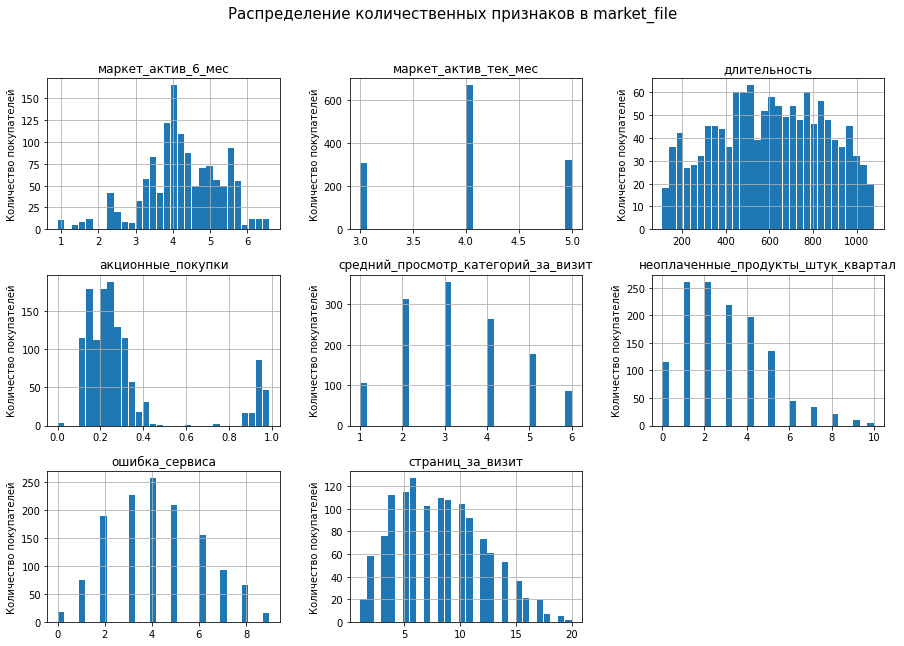

In [22]:
plot_num_feat(market_file, title='market_file')

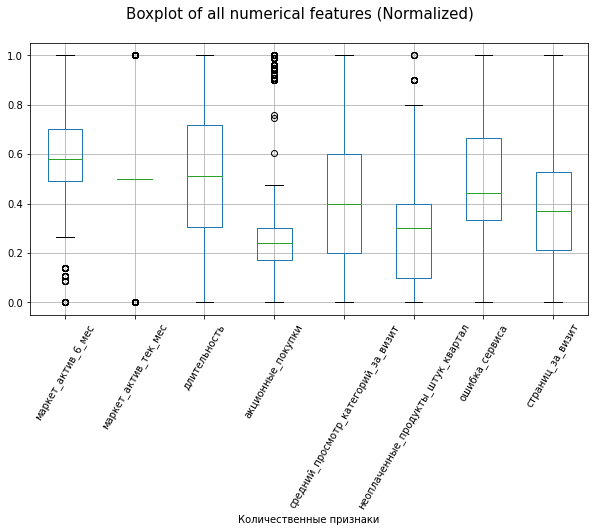

In [23]:
# Choose num columns
market_file_num = market_file.select_dtypes(include=['number'])

# Normalize the numerical columns using MinMaxScaler
scaler = MinMaxScaler()
market_file_scaled = pd.DataFrame(scaler.fit_transform(market_file_num), columns=market_file_num.columns)

# Create boxplot of the normalized data
axes = market_file_scaled.boxplot(figsize=(10, 5))

# Set titles
plt.suptitle('Boxplot of all numerical features (Normalized)', fontsize=15)
plt.xlabel('Количественные признаки')
plt.xticks(rotation=60)

# Show the plot
plt.show()

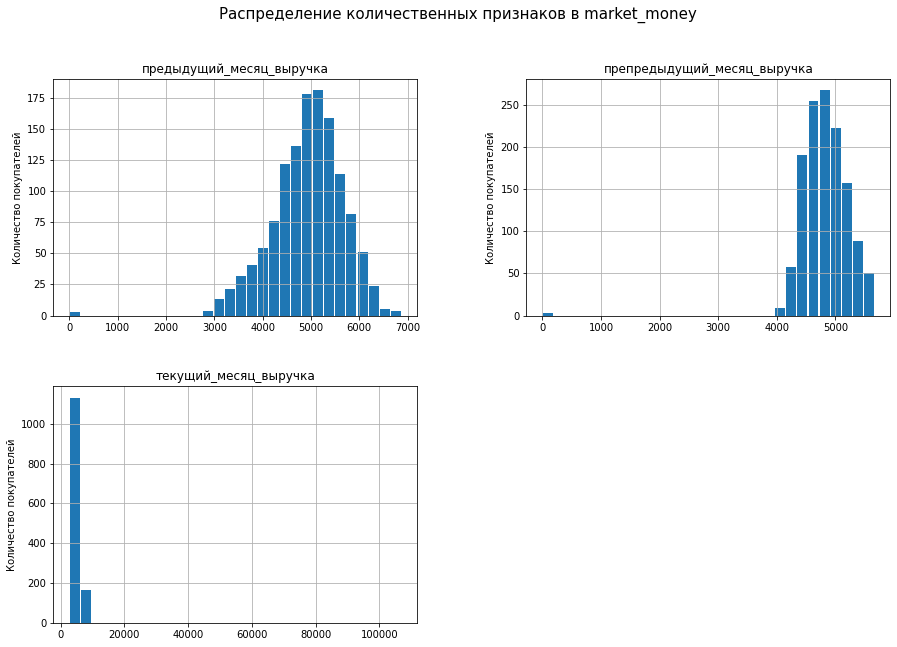

In [24]:
plot_num_feat(market_money, title='market_money')

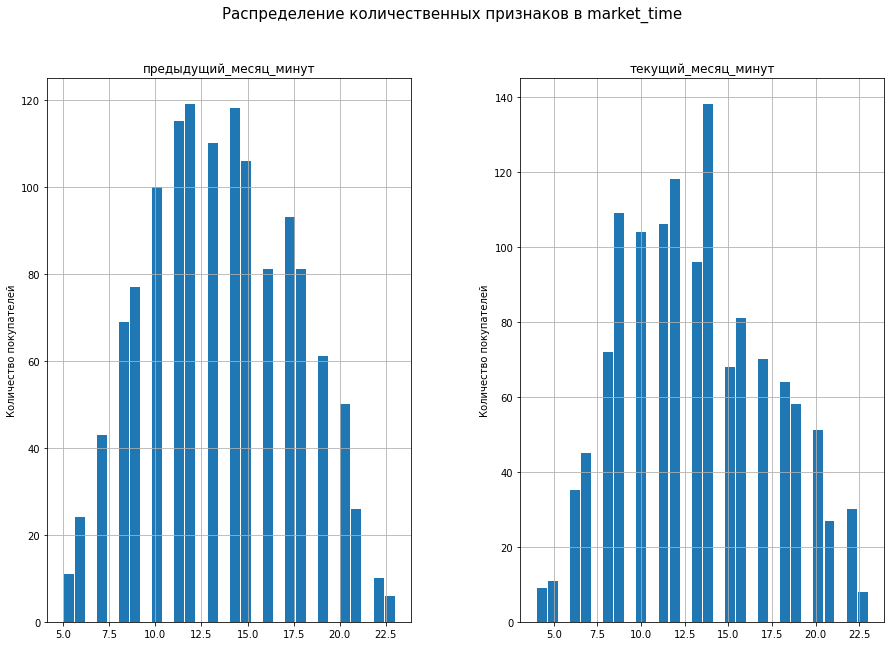

In [25]:
plot_num_feat(market_time, title='market_time')

Все количественные признаки кроме "акционные_покупки" имеют близкое к нормальному распределению. акционные_покупки выглядят так как будно у них есть две категории. 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка' имеют покупателей, у которых не было покупок, возможно их придется удалить.

### Качественные признаки <a class='anchor' id='4_2-bullet'></a>

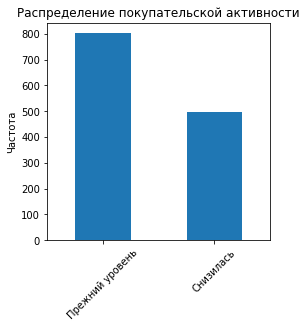

In [26]:
# Plot the target variable
market_file['покупательская_активность'].value_counts().plot(kind='bar',
                                                             figsize=(4, 4),
                                                             rot=45,
                                                             legend=None,
                                                             title=f'Распределение покупательской активности')
plt.ylabel('Частота')
plt.show()

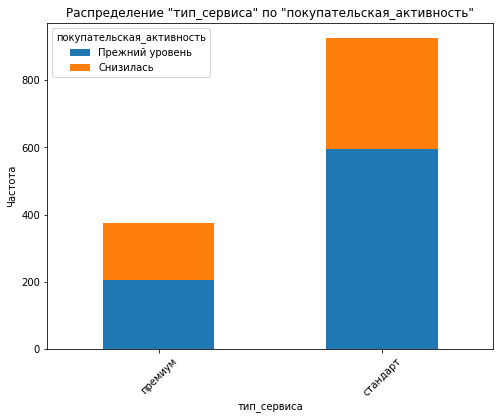

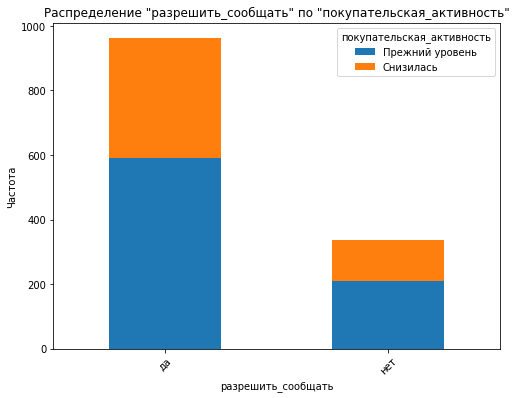

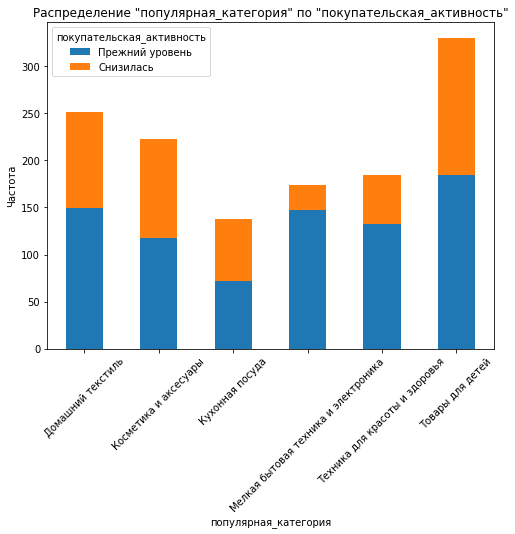

In [27]:
def plot_cat_cols(df, values):
    """
    Plots stacked bar charts for each categorical column in the DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the data.
    values (str): The column to use for grouping (hue) in the stacked bar chart.
    """
    # Find categorical columns
    cat_cols = df.select_dtypes(exclude=['number']).drop('покупательская_активность', axis=1).columns
    
    # Plot distribution with stacked bars
    for col in cat_cols:
        # Create a pivot table that groups by the current categorical column and `values`
        cat_type_hist = df.pivot_table(index=col, columns=values, aggfunc='size', fill_value=0)
        
        # Plot as a stacked bar chart
        cat_type_hist.plot(kind='bar', stacked=True, figsize=(8, 6), rot=45)
        plt.title(f'Распределение "{col}" по "{values}"')
        plt.ylabel('Частота')
        plt.xlabel(col)
        plt.legend(title=values)
        plt.show()

# Display the plots
plot_cat_cols(market_file, values='покупательская_активность')

Таргет имеет небольшой дисбаланс, поэтому более подходящими метриками для тестирования будут f1_score или roc_auc_score. Мелкая бытовая техника и электроника может быть хорошим показателем для отнесения покупателей к покупательской активности с прежним уровнем.

### Неактивные покупатели <a class='anchor' id='4_3-bullet'></a>

In [28]:
custom_to_exclude = market_money.query('(предыдущий_месяц_выручка < 1 & препредыдущий_месяц_выручка < 1) | (текущий_месяц_выручка > 20000)') \
                                .index \
                                .to_list()

In [29]:
print(custom_to_exclude)

[215348, 215357, 215359, 215380]


Список с покупателями без покупок в прошлом.

**Вывод:**
Все количественные признаки кроме "акционные_покупки" имеют близкое к нормальному распределению. акционные_покупки выглядят так как будно у них есть две категории. Таргет имеет небольшой дисбалансю Определили список с покупателями без покупок в прошлом.

## Объединение таблиц <a class='anchor' id='1_3-bullet'></a>

### Объединение таблиц <a class='anchor' id='5_1-bullet'></a>

In [30]:
# Create a new df with joined info
df = market_file.join([market_money, market_time])

In [31]:
# Check for missing values after join
display(df.isna().sum())

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_выручка                  0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

### Удаление неактивных покупателей <a class='anchor' id='5_2-bullet'></a>

In [32]:
# Remove customers
print('Размеры до удаления:', df.shape)
df = df.drop(custom_to_exclude)
print('Размеры после удаления:', df.shape)

Размеры до удаления: (1300, 17)
Размеры после удаления: (1296, 17)


### Биннинг <a class='anchor' id='5_3-bullet'></a>

In [33]:
# Feature engineering
df['акционные_покупки_кат'] = pd.cut(df['акционные_покупки'], bins=2)
print(df['акционные_покупки_кат'].value_counts())

(0.109, 0.55]    1129
(0.55, 0.99]      167
Name: акционные_покупки_кат, dtype: int64


**Вывод:**
Мы обьединили необходимые датасеты по id, удалили неактивных покупателей (3), провели биннинг признака - акционные_покупки.

## Корреляционный анализ  <a class='anchor' id='1_3-bullet'></a>

### Количественные признаки <a class='anchor' id='6_1-bullet'></a>

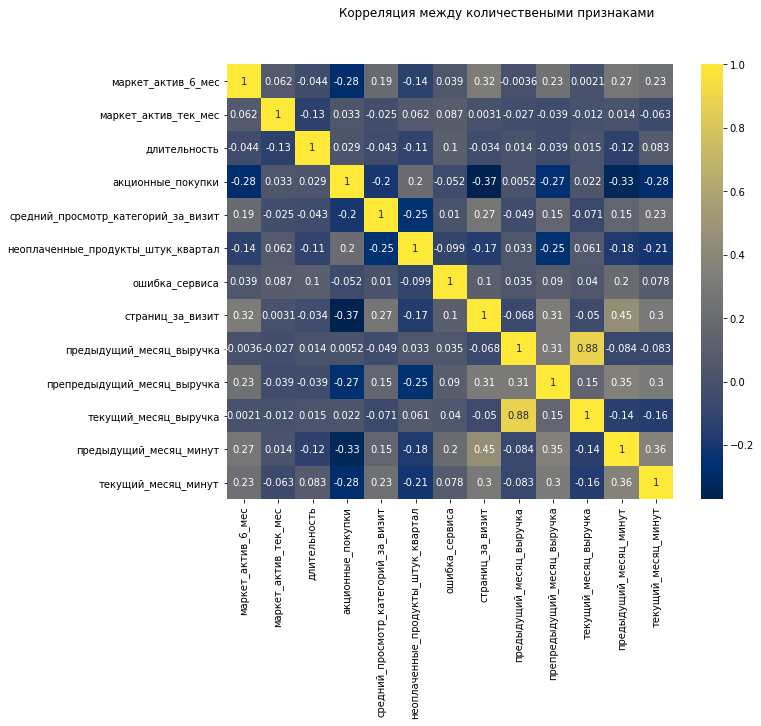

In [34]:
# Plot correlation between numeric features
numeric_feat = df.select_dtypes(include='number').columns.to_list()

plt.figure(figsize=(10, 8))
plt.suptitle('Корреляция между количествеными признаками')
sns.heatmap(df[numeric_feat].corr(method='spearman'), annot=True, cmap='cividis')
plt.show()

Используем кореляцию спирмена для количественных признаков потом что не все признаки нормально распределены. Мультиколлинерность между новым созданным признаком и 'акционные_покупки', где последний мы удалим позже.

### Количественные и качественные признаки <a class='anchor' id='6_2-bullet'></a>

In [35]:
df.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц_выручка',
       'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
       'предыдущий_месяц_минут', 'текущий_месяц_минут',
       'акционные_покупки_кат'],
      dtype='object')

In [36]:
# Prepare data for the correlation analysis
data_types = {
    'покупательская_активность':'categorical',
    'тип_сервиса':'ordinal',
    'разрешить_сообщать':'categorical',
    'маркет_актив_6_мес':'interval',
    'маркет_актив_тек_мес':'interval',
    'длительность':'interval',
    'акционные_покупки':'interval',
    'популярная_категория':'categorical',
    'средний_просмотр_категорий_за_визит':'interval',
    'неоплаченные_продукты_штук_квартал':'interval',
    'ошибка_сервиса':'interval',
    'страниц_за_визит':'interval',
    'предыдущий_месяц_выручка':'interval',
    'препредыдущий_месяц_выручка':'interval',
    'текущий_месяц_выручка':'interval',
    'предыдущий_месяц_минут':'interval',
    'текущий_месяц_минут':'interval',
    'акционные_покупки_кат':'categorical'
}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in df.columns]
interval_cols

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'предыдущий_месяц_выручка',
 'препредыдущий_месяц_выручка',
 'текущий_месяц_выручка',
 'предыдущий_месяц_минут',
 'текущий_месяц_минут']

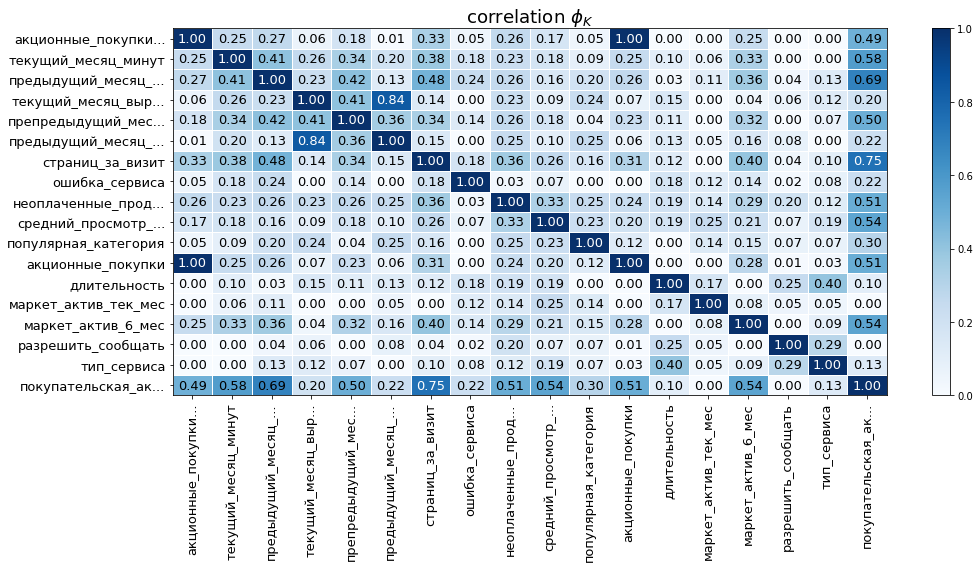

In [37]:
# Create phik matrix
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# Plot Correlation
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues',
                        title=r'correlation $\phi_K$', fontsize_factor=1.3,
                        figsize=(15,8))
plt.tight_layout()

'акционные_покупки', 'страниц_за_визит', 'предыдущий_месяц_минут', 'текущий_месяц_минут' показывают высокую кореляцию к покупательской активности.Хотя такие признаки как 'текущий_месяц_минут', 'текущий_месяц_выручка' могут содержать утечку информации и быть неполными, поэтому мы их удалим. 'маркет_актив_тек_мес' и 'разрешить_сообщать' имеют низкую корреляцию к таргету, поэтому мы тоже удалим.

In [ ]:
# Create list for all custemer activity
customer_activ_list = list(df['покупательская_активность'].unique())

# Plot correlation for each category
for a in customer_activ_list:
    
    # Create phik matrix
    phik_overview = df[df['покупательская_активность'] == a] \
                    .drop(['покупательская_активность'], axis=1) \
                    .phik_matrix(interval_cols=interval_cols)

    # Plot Correlation
    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index, 
                            vmin=0,
                            vmax=1,
                            color_map='Blues',
                            title=f'correlation $\phi_K$ for customer activity - {a}',
                            fontsize_factor=1.3,
                            figsize=(15,8))
    plt.tight_layout()
    plt.show()

### Удаление признаков <a class='anchor' id='6_3-bullet'></a>

In [39]:
df = df.drop(
    ['разрешить_сообщать', 'маркет_актив_тек_мес', 'акционные_покупки'],
    axis=1)

**Вывод:**
Мульти коллинерность между новым созданным признаком и 'акционные_покупки', где последний мы удалили. 'маркет_актив_тек_мес' и 'разрешить_сообщать' имеют низкую корреляцию к таргету, поэтому мы тоже удалили.

## Использование пайплайнов

### Подготовка данных <a class='anchor' id='7_1-bullet'></a>

In [40]:
# Split data
X = df.drop('покупательская_активность', axis=1)
y = df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, X_test.shape)

(972, 14) (324, 14)


In [ ]:
# Encode target variable
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(label_encoder.classes_)

In [42]:
# Lists with columns to preprocess
ohe_columns = ['популярная_категория', 'акционные_покупки_кат']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'длительность',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'предыдущий_месяц_выручка', 
               'препредыдущий_месяц_выручка', 'предыдущий_месяц_минут',
              'текущий_месяц_выручка', 'текущий_месяц_минут']
tar_columns = ['покупательская_активность']

### Первый Pipeline <a class='anchor' id='7_2-bullet'></a>

In [43]:
# First pipeline for the data preprocessing
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [
        ('SimpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['стандарт', 'премиум']],
                               handle_unknown='use_encoded_value',
                               unknown_value=np.nan)),
        ('SimpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [44]:
# Combined
data_preprocessor = ColumnTransformer(
    [
        ('ohe',ohe_pipe, ohe_columns),
        ('ord',ord_pipe, ord_columns),
        ('num',MinMaxScaler(), num_columns)
    ]
)

### Финальный Pipeline <a class='anchor' id='7_3-bullet'></a>

In [45]:
pipe_final = Pipeline(
    [
        ('preprocessor',data_preprocessor),
        ('models',LogisticRegression(random_state=RANDOM_STATE))
    ]
)

### Поиск гиперпараметров <a class='anchor' id='7_4-bullet'></a>

In [46]:
param_grid = [
    {
        'models':[LogisticRegression(solver='liblinear',
                                     penalty='l1',
                                     random_state=RANDOM_STATE)],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf':range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        
    },
    {
        'models':[SVC(kernel = 'poly', probability= True, random_state=RANDOM_STATE)],
        'models__degree': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [47]:
# Init Randomized Search
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=25
)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория',
                                                                                'акционные_покупки_кат']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('SimpleImpu...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [48]:
rs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'акционные_покупки_кат']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(stra...
                                                  ['маркет_актив_6_мес',
                                                   'длительность',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_выручка',
                                                   'препредыдущий_месяц_выручка',
                                                   'предыдущий_месяц_минут',
                                                   'текущий_месяц_выручка',
                                                   'текущий_месяц_минут'])])),
                ('models',
                 LogisticRegression(C=4, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [49]:
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(rs.best_score_, 4))

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_pred = rs.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred):.4f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'акционные_покупки_кат']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_o

In [50]:
rs_results = pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score')

In [51]:
pd.set_option('display.max_colwidth', None)
display(rs_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_neighbors,param_models,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,...,param_models__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.021747,0.000257,0.009527,0.000225,StandardScaler(),NaN,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",NaN,NaN,NaN,...,NaN,"{'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}",0.902167,0.900889,0.887838,0.919144,0.880631,0.898134,0.013249,1
18,0.092468,0.008199,0.011854,0.000326,MinMaxScaler(),NaN,"SVC(kernel='poly', probability=True, random_state=42)",NaN,NaN,NaN,...,4.0,"{'preprocessor__num': MinMaxScaler(), 'models__degree': 4, 'models': SVC(kernel='poly', probability=True, random_state=42)}",0.859839,0.883889,0.863739,0.885023,0.850000,0.868498,0.013782,2
8,0.022425,0.000867,0.009606,0.000398,MinMaxScaler(),NaN,DecisionTreeClassifier(random_state=42),4.0,5.0,4.0,...,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 5, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}",0.842584,0.849556,0.860417,0.865090,0.787218,0.840973,0.028020,3
22,0.025713,0.004344,0.011135,0.001589,MinMaxScaler(),NaN,DecisionTreeClassifier(random_state=42),5.0,5.0,5.0,...,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}",0.825888,0.839111,0.875056,0.844651,0.810811,0.839103,0.021441,4
5,0.021713,0.001823,0.008666,0.000242,passthrough,NaN,DecisionTreeClassifier(random_state=42),3.0,5.0,5.0,...,NaN,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 3, 'models__min_samples_leaf': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}",0.825888,0.839111,0.875056,0.844651,0.810811,0.839103,0.021441,4


**Вывод:**
Мы разделили данные, закодировали таргет и создали пайплайн для разных категорий признаков, а так же включили и итоговый пайплан рандомный поиск лучшей модели с лучгими гиперпараметрами. Наша лучшая модель - LogisticRegression с гипперпараментрами C=4, penalty='l1', solver='liblinear'. Мы выбрали roc_auc_score так как она лучше отражает дисбаланс классов. Метрика лучшей модели на тренировочной выборке: 0.8926. Метрика ROC-AUC на тестовой выборке: 0.8640. 

## Анализ важности признаков

### Встроенная функция <a class='anchor' id='8_1-bullet'></a>

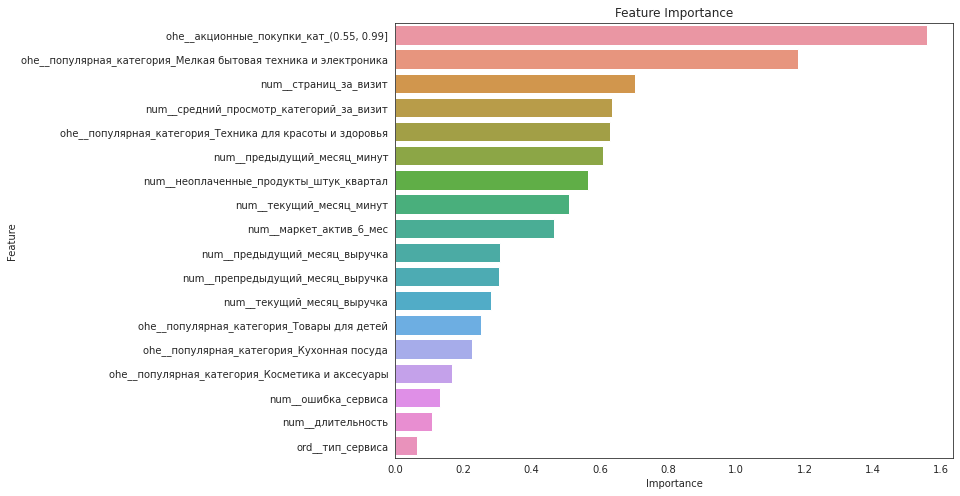

In [52]:
# Accessing the best estimator's coefficients
final_model = rs.best_estimator_.named_steps['models']

# Access the preprocessor from the pipeline
preprocessor = rs.best_estimator_.named_steps['preprocessor']

# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Create a df for feature importance
coefficients = final_model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

### SHAP <a class='anchor' id='8_2-bullet'></a>

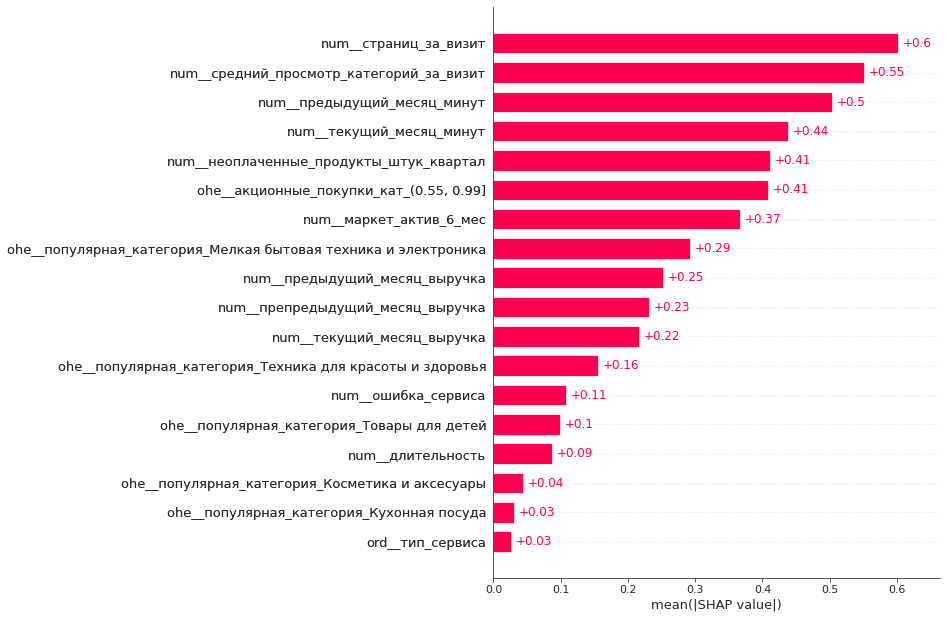

In [53]:
# Prepare data
X_train_transformed = rs.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_transformed = rs.best_estimator_.named_steps['preprocessor'].transform(X_test)

# Get feature names
feature_names = rs.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Ensure your transformed data (X_test_transformed) has the right columns
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Display the plot
explainer = shap.LinearExplainer(final_model, X_test_transformed)
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=20)

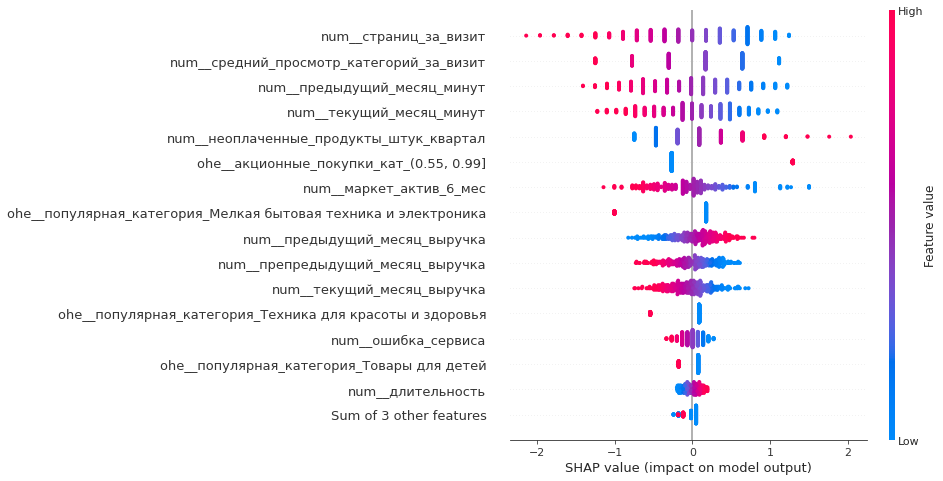

In [54]:
shap.plots.beeswarm(shap_values, max_display=16) 

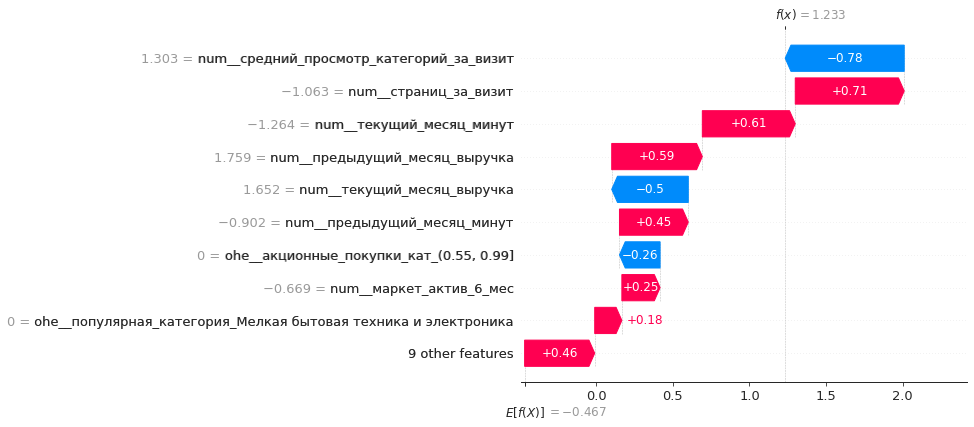

In [55]:
shap.plots.waterfall(shap_values[181])

**Вывод:**
По встроенным в логистическую регрессию функцию feature_importnace и SHAP-анализу, мы видим, что такие признаки как акционные_покупки_кат, популярная_категория, страниц_за_визит, средний_просмотр_категорий_за_визит имеют важное значение в присваивании покупателького уровня.
Чем больше значение признака акционные_покупки_кат_(0.55, 0.99], тем выше SHAP-значения. У наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1 (сниженная покупательская активность).популярная_категория_Мелкая бытовая техника наоборот показтель отнесения покупателей с прежней покупательской активностью - 0.

## Сегментация покупателей <a class='anchor' id='9_1-bullet'></a>

In [56]:
y_pred = rs.predict_proba(X)[:,1]

In [57]:
# Make a dataframe from predictions

y_pred_df = pd.DataFrame(y_pred,
                         columns=['вероятность_снижения'],
                         index=X.index)
print(y_pred_df.shape)

(1296, 1)


In [58]:
# Join more info
imp_features = ['популярная_категория', 'акционные_покупки_кат']
df_segment = y_pred_df.join([money, df[imp_features]])
display(df_segment.head())
print(df_segment.shape)

,вероятность_снижения,прибыль,популярная_категория,акционные_покупки_кат
id,,,,
215349,0.933409,4.16,Товары для детей,"(0.55, 0.99]"
215350,0.523365,3.13,Домашний текстиль,"(0.109, 0.55]"
215351,0.727437,4.87,Товары для детей,"(0.55, 0.99]"
215352,0.961328,4.21,Товары для детей,"(0.55, 0.99]"
215353,0.660560,3.95,Домашний текстиль,"(0.109, 0.55]"


(1296, 4)


In [68]:
# Dataframe with customers with high churn prob and high spends
df_segment_churn = df_segment.query('вероятность_снижения >= 0.7 & прибыль > 3')

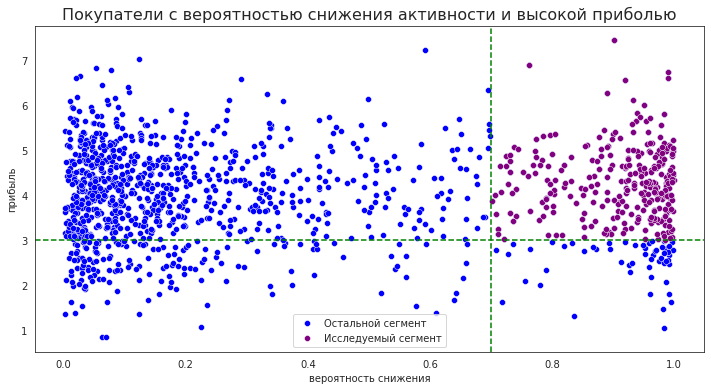

In [77]:
# Plot high churn prob and high spends
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_segment, x='вероятность_снижения', y='прибыль', label='Остальной сегмент', color='blue')
sns.scatterplot(data=df_segment_churn, x='вероятность_снижения', y='прибыль', label='Исследуемый сегмент', color='purple')
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.xlabel('вероятность снижения')
plt.title('Покупатели с вероятностью снижения активности и высокой прибылью', fontsize=16)
plt.legend()
plt.show()

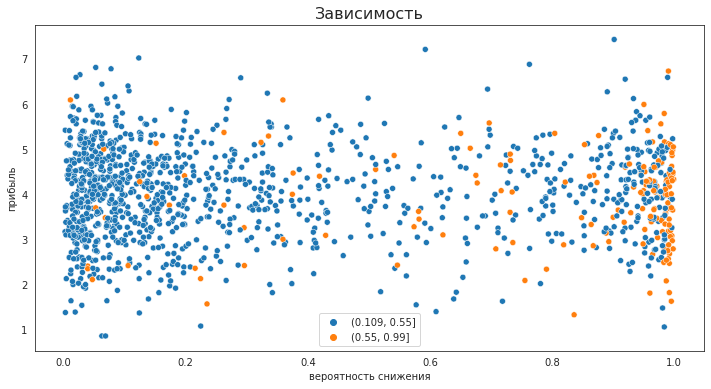

In [75]:
# Plot high churn prob and purchases types
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_segment, x='вероятность_снижения', y='прибыль', hue='акционные_покупки_кат')
plt.title('Зависимость', fontsize=16)
plt.xlabel('Покупатели c вероятность снижения по типу акционных покупок')
plt.legend()
plt.show()

**Вывод:**
Мы видим группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности, в группе с прежней почти нет покупателей с высокой долей покупок по акции. Так же другой сегмент прокупателей это клиены с высокой вероятностью снижения активности (>=0.7) и высокой прибылью (>=3).

## Итоговые выводы <a class='anchor' id='10_1-bullet'></a>

**Краткий обзор проведённой работы:** Мы изменили тип данных некоторых колонок для удобства, убрали неявные и явные дупликаты, исключили явные выбросы. Изменили тип данных некоторых столбцов. Из имеющейся информации мы создали новые столбцы с дополнительной информацией такой как, группировка по покупкам по акциям. Мы провели коррелиционный анализ количественных и качественных признаков и выявили важные и лишние для таргетов признаки. Создали пайплайн для предобработки данных и поиска лучшей модели.

**Главные выводы:** Мы создали ML Pipline для обработки входных данных и поиска лучшей модели и ее гиперпараметров. Для модели мы добавили новый признак 'акционные_покупки_кат', где корреляционный анализ показал высокую зависимость с таргетом. Мы исключили доподнительные 4 признака, так как по коррелиционному анализу эти признаки не влияли на таргет или предоставляли утечку информации. Остальные признаки были обработаны как в задаче линейной регрессии. Наша лучшая модель - LogisticRegression с гипперпараментрами C=4, penalty='l1', solver='liblinear'. Мы выбрали roc_auc_score так как она лучше отражает дисбаланс классов. Метрика лучшей модели на тренировочной выборке: 0.8926. Метрика ROC-AUC на тестовой выборке: 0.8640. По встроенным в логистическую регрессию функцию feature_importnace и SHAP-анализу, мы видим, что такие признаки как акционныепокупки_кат, популярная_категория, страниц_за_визит, средний_просмотр_категорий_за_визит имеют важное значение в присваивании покупателького уровня. 

**Рекомендации:** Мы видим группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности, в группе с прежней почти нет покупателей с высокой долей покупок по акции. Так же другой сегмент прокупателей это клиены с высокой вероятностью снижения активности (>=0.7) и высокой прибылью (>=3). Для выделнной группы покупателей рекомендованно сохранять определенный уровень акций, чтобы у них не снизила покупательская активность.